## Figure Eight

Generate simulation:

┌ Info: Saved animation to C:\Users\jimmy\Documents\USC\sem5-2022\PHYS-304\research-paper\ThreeBodyBot-master\NumericsTutorial\tmp.gif
└ @ Plots C:\Users\jimmy\.julia\packages\Plots\Pn7Zn\src\animation.jl:149


Plots.AnimatedGif("C:\\Users\\jimmy\\Documents\\USC\\sem5-2022\\PHYS-304\\research-paper\\ThreeBodyBot-master\\NumericsTutorial\\tmp.gif")
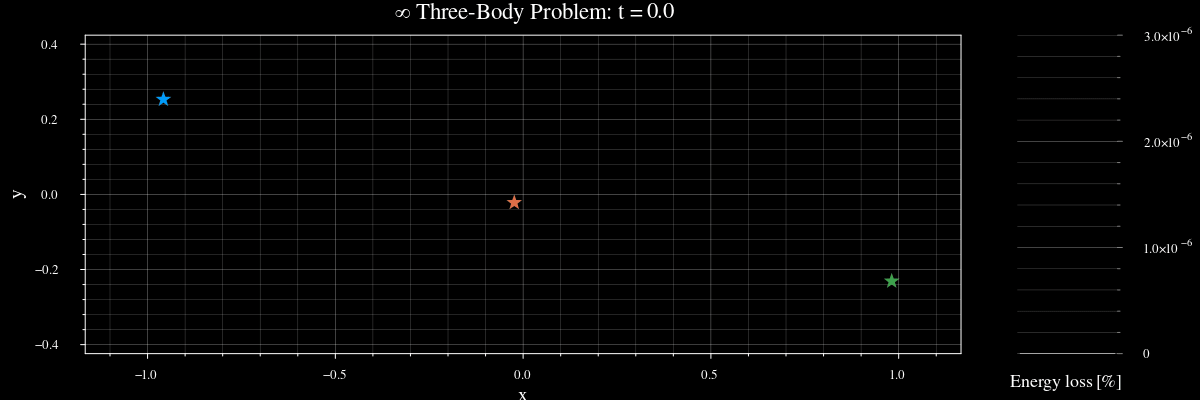

In [25]:
function Δr(coords,masses,nBodies,G) #this is a generalized difference calculator for nBodies, different masses, and different values of G
    x,y,vx,vy = deepcopy(coords) #in Julia saying a = b just sets pointers by default, this creates a physical copy in memory
    Δ = deepcopy(coords)
    for n=1:nBodies
        xn = x[n]; yn = y[n] #assign them new variables here for computational efficiency, minimize calls to access memory
        Δvx = 0.; Δvy = 0.
        for i=1:nBodies #generalizing for later n-body problem
            if i!=n #only calculate if not self
                sep = sqrt((xn-x[i])^2+(yn-y[i])^2) #euclidean distance
                Δvx -= G*masses[i]*(xn - x[i])/sep^3 #change in velocity from each mass on mass n
                Δvy -= G*masses[i]*(yn - y[i])/sep^3
            end
        end
        Δ[3][n] = Δvx #change in velocity = a*t
        Δ[4][n] = Δvy
    end
    Δ[1] = vx #change in position = v*t
    Δ[2] = vy
    return Δ
end

function step!(coords,masses,Δt,nBodies=3,G=6.67408313131313e-11) #1 RK4 step for each body's coordinates, mutates coords
    k1 = Δt.*Δr(coords,masses,nBodies,G)
    k2 = Δt.*Δr(coords .+ k1./2,masses,nBodies,G)
    k3 = Δt.*Δr(coords .+ k2./2,masses,nBodies,G)
    k4 = Δt.*Δr(coords .+ k3,masses,nBodies,G)
    coords .+= (k1 .+ 2.0.*k2 .+ 2.0.*k3 .+ k4)./6
    return coords #return changes in position and velocity
end

#Initial conditions setup for figure eight from chenciner
M = [1,1,1] #m1=m2=m3
x = [-0.97000436,0.,0.97000436] #x1 = -x3, x2 = 0
y = [0.24208753,0.,-0.24208753] #y1 = -y3, y2 = 0
vx = [0.4662036850,-0.933240737,0.4662036850] #v1x = v3x
vy = [0.4323657300,-0.86473146,0.4323657300] #v1y = v3y
Ei = -1/√((2*0.97000436)^2+(2*0.24208753)^2) - 2/√(0.97000436^2+0.24208753^2) + 0.5*sum(vx.^2 .+ vy.^2)#r23 = r12

coords = [x,y,vx,vy] #array of initial conditions 
time = range(0,stop=6.3259*8,length=2*1001); Δt = time[2]-time[1] #the periodicity of this system is ~6.3259 in natural time units

X = zeros(3,length(time)); Y = zeros(3,length(time)); VX = zeros(3,length(time)); VY = zeros(3,length(time)) #initialize tracking arrays
for i = 1:length(time)
    coords = step!(coords,M,Δt,3,1) #evolve the system at each time step
    X[:,i] = coords[1]; Y[:,i] = coords[2] #keep track of position at each time step
    VX[:,i] = coords[3]; VY[:,i] = coords[4]
end

using Plots, Plots.Measures
#make a simple animation of our results
@gif for i=1:length(time)
    p1=plot(size=(1000,400),widen=true,aspect_ratio=:equal,xlims=(-1.1,1.1),ylims=(-0.4,0.4),xlabel="x",ylabel="y",title="∞ Three-Body Problem: t = ",
    background_color=:black,gridalpha=0.5,minorgridalpha=0.3,framestyle=:box,margins=4mm,titlefonthalign=:left,titlefontsize=14,guidefontsize=10,labelfontsize=12)
    #p1=annotate!(0.6,1.,Plots.text("$(round(time[i],sigdigits=3))","white",14))
    p1=annotate!([(0.33,0.49,("$(round(time[i],sigdigits=3))",14,:white,:left))]) #because it really annoys me when the title bounces around as the number changes
    p1=plot!(X[1,1:i],Y[1,1:i],label="",lw=2,linealpha=max.((1:i) .+ 100 .- i,20)/100)
    p1=plot!(X[2,1:i],Y[2,1:i],label="",lw=2,linealpha=max.((1:i) .+ 100 .- i,20)/100)
    p1=plot!(X[3,1:i],Y[3,1:i],label="",lw=2,linealpha=max.((1:i) .+ 100 .- i,20)/100)
    p1=scatter!([X[1,i]],[Y[1,i]],label="",marker=:star,c=1,markerstrokewidth=0,markersize=8)
    p1=scatter!([X[2,i]],[Y[2,i]],label="",marker=:star,c=2,markerstrokewidth=0,markersize=8)
    p1=scatter!([X[3,i]],[Y[3,i]],label="",marker=:star,c=3,markerstrokewidth=0,markersize=8)
    r12 = √((X[1,i]-X[2,i])^2+(Y[1,i]-Y[2,i])^2); r13 = √((X[1,i]-X[3,i])^2+(Y[1,i]-Y[3,i])^2); r23 = √((X[3,i]-X[2,i])^2+(Y[3,i]-Y[2,i])^2)
    U = -1/r12 - 1/r13 - 1/r23 #G = m = 1
    K = 0.5*sum(VX[:,i].^2 .+ VY[:,i].^2) #m=1
    ΔE = abs((U+K-Ei)/Ei)
    p2 = bar([ΔE],ylims=(0,3e-6),label="",xticks=false,xlabel="Energy loss [%]",ylabel="",grid=true,minorgrid=true,minorgridalpha=0.3,gridalpha=0.5,
        background_color=:black,framestyle=:grid,margins=3mm,c=:crimson,ymirror=true,widen=false,tickdirection=:out,yticks=true,yminorticks=true)
    #p2 = hline!([0.,1e-10,2e-10,3e-10],c=:white,label="")
    plot(p1,p2,layout=@layout([A B{0.1w}]),size=(1200,400))
end every 10

Generate stability plot:

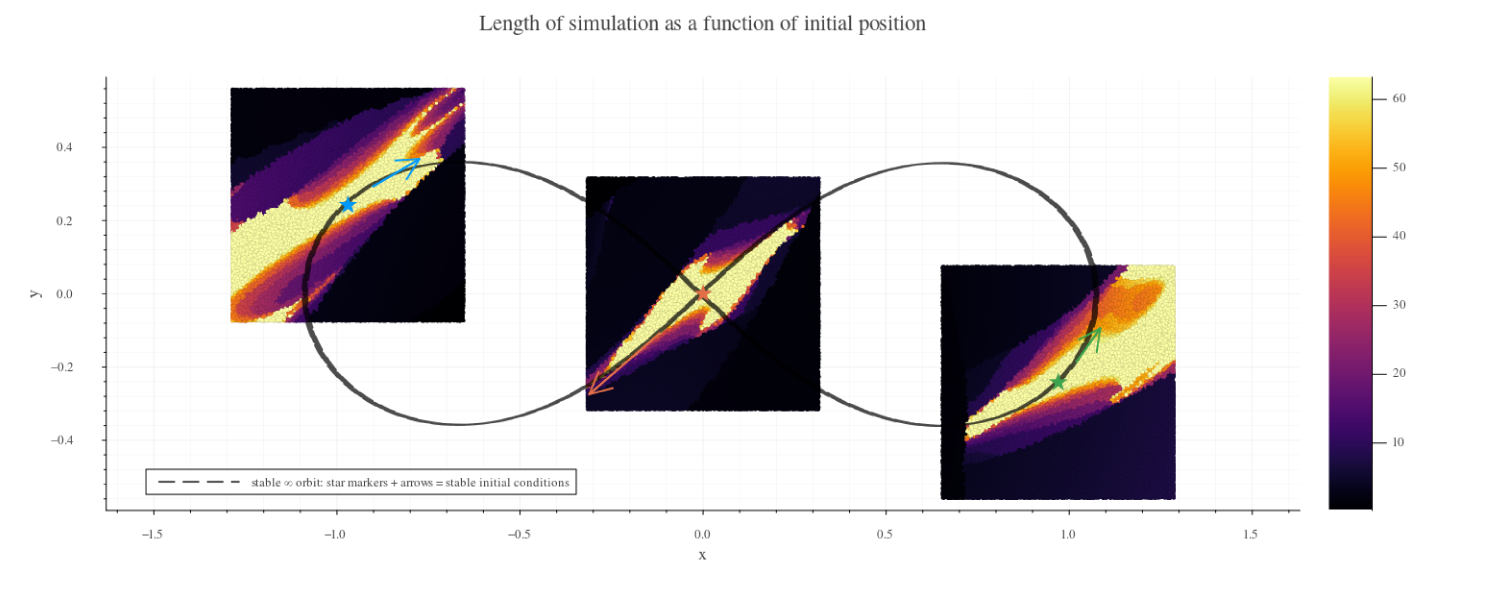

In [9]:
using Distributions
function detectCollisionsEscape(coords,Δt,maxSep) #this tells us if two bodies have "collided" or one has "escaped"
    x,y,vx,vy = coords
    V = sqrt.(vx.^2 .+ vy.^2)
    R = V.*Δt
    collision = false; collisionInds = nothing; escape = false; escapeInd = nothing
    for n=1:length(x)
        rn = R[n]; xn = x[n]; yn = y[n]
        for i=1:length(x) 
            if i!=n #don't check if we collided with ourselves!
                minSep = rn+R[i]
                sep = √((xn-x[i])^2+(yn-y[i])^2)
                if sep<minSep #collision!
                    collision = true
                    collisionInds = n,i
                    return collision,collisionInds,escape,escapeInd
                elseif sep>maxSep #escape!
                    escape = true
                    escapeInd = n
                    return collision,collisionInds,escape,escapeInd
                end
            end
        end
    end
    return collision,collisionInds,escape,escapeInd
end

function perturbTest(;body, δMax=0.1) #this function tests how long system lasts for a random small perturbation of the initial position of body 2
    #Initial conditions setup
    M = [1,1,1] #m1=m2=m3
    vx = [0.4662036850,-0.933240737,0.4662036850] #v1x = v3x
    vy = [0.4323657300,-0.86473146,0.4323657300] #v1y = v3y
    
    if body == 1
        x = [-0.97000436+rand(Uniform(-1.,1.))*√δMax,0.0,0.97000436] #x1 = -x3, x2 = 0 + perturbation
        y = [0.24208753+rand(Uniform(-1.,1.))*√δMax,0.0,-0.24208753] #y1 = -y3, y2 = 0 + perturbation
    elseif body == 2
        x = [-0.97000436,0.0+rand(Uniform(-1.,1.))*√δMax,0.97000436] #x1 = -x3, x2 = 0 + perturbation
        y = [0.24208753,0.0+rand(Uniform(-1.,1.))*√δMax,-0.24208753] #y1 = -y3, y2 = 0 + perturbation
    elseif body == 3
        x = [-0.97000436,0.0,0.97000436+rand(Uniform(-1.,1.))*√δMax] #x1 = -x3, x2 = 0 + perturbation
        y = [0.24208753,0.0,-0.24208753+rand(Uniform(-1.,1.))*√δMax] #y1 = -y3, y2 = 0 + perturbation
    end
    
    coords = [x,y,vx,vy] #array of initial conditions 
    initCoords = deepcopy([x[body],y[body]]) #keep track for output later
    time = range(0,stop=6.3259*10,length=1001); Δt = time[2]-time[1] #the periodicity of this system is ~6.3259 in these units
    maxSep = 10*√((2*0.97000436)^2+(2*0.24208753)^2) #biggest distance apart is at start between bodies 1-3
    collision,collisionInds,escape,escapeInd = false,nothing,false,nothing
    for i = 1:length(time)
        coords = step!(coords,M,Δt,3,1) #update coords at each time step
        collision,collisionInds,escape,escapeInd = detectCollisionsEscape(coords,Δt,maxSep) #has something collided or escaped?
        if collision == true || escape == true #if something escapes or collides the simulation has ended, return values
            return collision,collisionInds,escape,escapeInd,initCoords,time[i]
        end
    end
    return collision,collisionInds,escape,escapeInd,initCoords,time[end]
end

using DataFrames,Printf
N = 100000 #number of random trials
Names = [:collision,:escape,:T,:x,:y,:r] #names for columns 
Types = [Bool,Bool,Float64,Float64,Float64,Float64] #types for columns
df1 = DataFrame(Names .=> [Vector{type}(undef,N) for type in Types]) #make empty df with column names and types 
df2 = DataFrame(Names .=> [Vector{type}(undef,N) for type in Types])
df3 = DataFrame(Names .=> [Vector{type}(undef,N) for type in Types])

for i=1:N
    if i%(N/1000) == 0; print("$(@sprintf("%.2f",i/N*100)) % complete\r"); end#output percent tracker
    collision,collisionInds,escape,escapeInd,initCoords,T = perturbTest(body=1) #perform a random test
    df1.collision[i] = collision; df1.escape[i] = escape; df1.T[i] = T; df1.x[i] = initCoords[1]; df1.y[i] = initCoords[2]; df1.r[i] = √(initCoords[1]^2+initCoords[2]^2) #put results in df
end
    
for i=1:N
    if i%(N/1000) == 0; print("$(@sprintf("%.2f",i/N*100)) % complete\r"); end#output percent tracker
    collision,collisionInds,escape,escapeInd,initCoords,T = perturbTest(body=2) #perform a random test
    df2.collision[i] = collision; df2.escape[i] = escape; df2.T[i] = T; df2.x[i] = initCoords[1]; df2.y[i] = initCoords[2]; df2.r[i] = √(initCoords[1]^2+initCoords[2]^2) #put results in df
end

for i=1:N
    if i%(N/1000) == 0; print("$(@sprintf("%.2f",i/N*100)) % complete\r"); end#output percent tracker
    collision,collisionInds,escape,escapeInd,initCoords,T = perturbTest(body=3) #perform a random test
    df3.collision[i] = collision; df3.escape[i] = escape; df3.T[i] = T; df3.x[i] = initCoords[1]; df3.y[i] = initCoords[2]; df3.r[i] = √(initCoords[1]^2+initCoords[2]^2) #put results in df
end    

df = vcat(df1, df2, df3)    

#visualize results!
p = scatter(df.x,df.y,marker_z=df.T,markerstrokewidth=0,markersize=2,label="",margins=5mm)
p = plot!(X[2,:],Y[2,:],linestyle=:dash,c=:black,lw=2,linealpha=0.7,label="stable ∞ orbit: star markers + arrows = stable initial conditions")
p = scatter!([-0.97000436,0.0,0.97000436],[0.24208753,0.0,-0.24208753],label="",marker=:star,markersize=10,markerstrokewidth=0,c=[1,2,3])
p = quiver!(X[1,5:100:50],Y[1,5:100:50],quiver=(VX[1,5:100:50]./5,VY[1,5:100:50]./5),label="",lw=2,c=1) #add arrows
p = quiver!(X[3,5:100:50],Y[3,5:100:50],quiver=(VX[3,5:100:50]./5,VY[3,5:100:50]./5),label="",lw=2,c=3) 
p = quiver!(X[2,5:30:30],Y[2,5:30:30],quiver=(VX[2,5:30:30]./5,VY[2,5:30:30]./5),label="",lw=2,c=2)
p = plot!(size=(1500,600),aspect_ratio=:equal,title="Length of simulation as a function of initial position",xlabel="x",ylabel="y",widen=true)
png(p,"chaos.png"); closeall() #this one slows things down and takes forever to display, so this "hack" saves as png, closes plots, then opens the picture as a new "plot"
using Images
img = load("chaos.png")
plot(img,size=(size(img)[2],size(img)[1]),axis=false,frame=false,ticks=false)
#to do a real heat map need to go through every possible y at each x on a grid, but this random approach is more fun I think and illustrates the same thing 

## Lagrange Choreography
Generate simulation

┌ Info: Saved animation to C:\Users\jimmy\Documents\USC\sem5-2022\PHYS-304\research-paper\ThreeBodyBot-master\NumericsTutorial\tmp.gif
└ @ Plots C:\Users\jimmy\.julia\packages\Plots\Pn7Zn\src\animation.jl:149


Plots.AnimatedGif("C:\\Users\\jimmy\\Documents\\USC\\sem5-2022\\PHYS-304\\research-paper\\ThreeBodyBot-master\\NumericsTutorial\\tmp.gif")
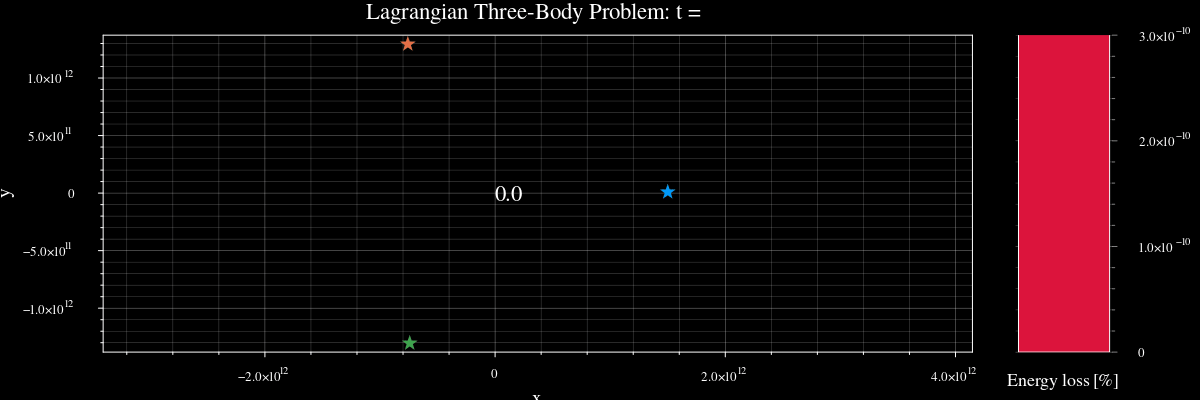

In [15]:
function Δr(coords,masses,nBodies,G) #this is a generalized version of what we had before for nBodies, different masses, and different values of G
    x,y,vx,vy = deepcopy(coords) #in Julia saying a = b just sets pointers by default, this creates a physical copy in memory
    Δ = deepcopy(coords)
    for n=1:nBodies
        xn = x[n]; yn = y[n] #assign them new variables here for computational efficiency, minimize calls to access memory
        Δvx = 0.; Δvy = 0.
        for i=1:nBodies #generalizing for later n-body problem
            if i!=n #only calculate if not self
                sep = sqrt((xn-x[i])^2+(yn-y[i])^2) #euclidean distance
                Δvx -= G*masses[i]*(xn - x[i])/sep^3 #change in velocity from each mass on mass n
                Δvy -= G*masses[i]*(yn - y[i])/sep^3
            end
        end
        Δ[3][n] = Δvx #change in velocity = a*t
        Δ[4][n] = Δvy
    end
    Δ[1] = vx #change in position = v*t
    Δ[2] = vy
    return Δ
end

function step!(coords,masses,Δt,nBodies=3,G=6.67408313131313e-11) #1 RK4 step for each body's coordinates, mutates coords
    k1 = Δt.*Δr(coords,masses,nBodies,G)
    k2 = Δt.*Δr(coords .+ k1./2,masses,nBodies,G)
    k3 = Δt.*Δr(coords .+ k2./2,masses,nBodies,G)
    k4 = Δt.*Δr(coords .+ k3,masses,nBodies,G)
    coords .+= (k1 .+ 2.0.*k2 .+ 2.0.*k3 .+ k4)./6
    return coords #return changes in position and velocity
end

#Initial conditions setup -- you can modify these to make whatever three-body animations you want!
#Lagrange config. units: AU, km/s, Msun. need to convert to SI units
M = [100,100,100].*2e30 #m1=m2=m3
x = [10.0,-5.0,-5.0].*1.5e11 #convert to SI units
y = [0.0,8.66025403784439,-8.66025403784439].*1.5e11 
vx = [0.0,-62.07482333811008,62.07482333811008].*1e3
vy = [71.67783192831264,-35.83891596415632,-35.83891596415632].*1e3

coords = [x,y,vx,vy] #array of initial conditions 
d(coords,i1,i2) = sqrt((coords[1][i1]-coords[1][i2])^2+(coords[2][i1]-coords[2][i2])^2)
totalKi = sum(M.*(coords[3].^2 .+ coords[4].^2))/2

function getU(coords,nBodies,m,G)
    totalU = 0; indsList = [i for i=1:nBodies]
    for n = 1:nBodies-1
        totalU += -G*sum([m[n]*mOther for mOther in m[n+1:end]]./[d(coords,n,i) for i=n+1:nBodies])
    end
    return totalU
end
Ei = getU(coords,3,M,6.67408313131313e-11) + totalKi #total initial energy of system
yearSec = 365*24*3600
time = range(0,stop=4.1695*yearSec,length=1001); Δt = time[2]-time[1] #the periodicity of this system is ~4.1694585 years

X = zeros(3,length(time)); Y = zeros(3,length(time)); VX = zeros(3,length(time)); VY = zeros(3,length(time)) #initialize tracking arrays
for i = 1:length(time)
    coords = step!(coords,M,Δt,3,6.67408313131313e-11) #evolve the system at each time step
    X[:,i] = coords[1]; Y[:,i] = coords[2] #keep track of position at each time step
    VX[:,i] = coords[3]; VY[:,i] = coords[4]
end

using Plots.Measures
#make a simple animation of our results
@gif for i=1:length(time)
    p1=plot(size=(400,400),widen=true,aspect_ratio=:equal,xlabel="x",ylabel="y",title="Lagrangian Three-Body Problem: t = ",
    background_color=:black,gridalpha=0.5,minorgridalpha=0.3,framestyle=:box,margins=4mm,titlefonthalign=:left,titlefontsize=14,guidefontsize=10,labelfontsize=12)
    #p1=annotate!(0.6,1.,Plots.text("$(round(time[i],sigdigits=3))","white",14))
    p1=annotate!([(0.32,0.46,("$(round(time[i],sigdigits=3))",14,:white,:left))]) #because it really annoys me when the title bounces around as the number changes
    p1=plot!(X[1,1:i],Y[1,1:i],label="",lw=2,linealpha=max.((1:i) .+ 100 .- i,20)/100)
    p1=plot!(X[2,1:i],Y[2,1:i],label="",lw=2,linealpha=max.((1:i) .+ 100 .- i,20)/100)
    p1=plot!(X[3,1:i],Y[3,1:i],label="",lw=2,linealpha=max.((1:i) .+ 100 .- i,20)/100)
    p1=scatter!([X[1,i]],[Y[1,i]],label="",marker=:star,c=1,markerstrokewidth=0,markersize=8)
    p1=scatter!([X[2,i]],[Y[2,i]],label="",marker=:star,c=2,markerstrokewidth=0,markersize=8)
    p1=scatter!([X[3,i]],[Y[3,i]],label="",marker=:star,c=3,markerstrokewidth=0,markersize=8)
    r12 = √((X[1,i]-X[2,i])^2+(Y[1,i]-Y[2,i])^2); r13 = √((X[1,i]-X[3,i])^2+(Y[1,i]-Y[3,i])^2); r23 = √((X[3,i]-X[2,i])^2+(Y[3,i]-Y[2,i])^2)
    U = -1/r12 - 1/r13 - 1/r23 #G = m = 1
    K = 0.5*sum(VX[:,i].^2 .+ VY[:,i].^2) #m=1
    ΔE = abs((U+K-Ei)/Ei)
    p2 = bar([ΔE],ylims=(0,3e-10),label="",xticks=false,xlabel="Energy loss [%]",ylabel="",grid=true,minorgrid=true,minorgridalpha=0.3,gridalpha=0.5,
        background_color=:black,framestyle=:grid,margins=3mm,c=:crimson,ymirror=true,widen=false,tickdirection=:out,yticks=true,yminorticks=true)
    #p2 = hline!([0.,1e-10,2e-10,3e-10],c=:white,label="")
    plot(p1,p2,layout=@layout([A B{0.1w}]),size=(1200,400))
end every 10

Generate stability plot:

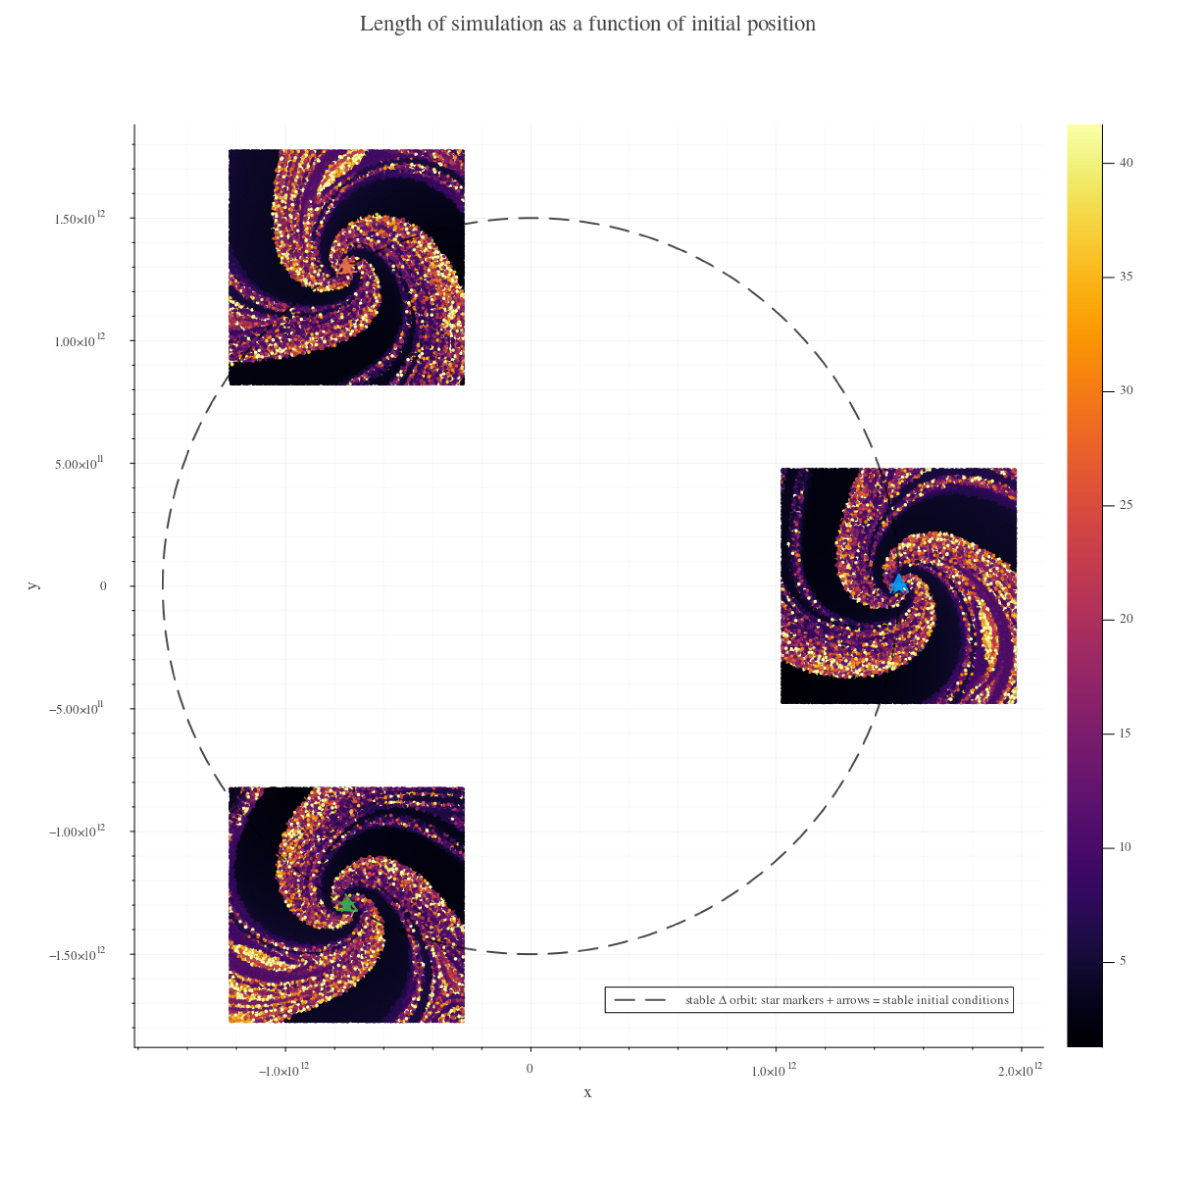

In [17]:
using Distributions
function detectCollisionsEscape(coords,Δt,maxSep) #this tells us if two bodies have "collided" or one has "escaped"
    x,y,vx,vy = coords
    V = sqrt.(vx.^2 .+ vy.^2)
    R = V.*Δt
    collision = false; collisionInds = nothing; escape = false; escapeInd = nothing
    for n=1:length(x)
        rn = R[n]; xn = x[n]; yn = y[n]
        for i=1:length(x) 
            if i!=n #don't check if we collided with ourselves!
                minSep = rn+R[i]
                sep = √((xn-x[i])^2+(yn-y[i])^2)
                if sep<minSep #collision!
                    collision = true
                    collisionInds = n,i
                    return collision,collisionInds,escape,escapeInd
                elseif sep>maxSep #escape!
                    escape = true
                    escapeInd = n
                    return collision,collisionInds,escape,escapeInd
                end
            end
        end
    end
    return collision,collisionInds,escape,escapeInd
end

function perturbTest(; body, δMax=10.0) #this function tests how long system lasts for a random small perturbation of the initial position of body 2
    #Initial conditions setup
    #Lagrange config. units: AU, km/s, Msun. need to convert to SI units
    M = [100,100,100].*2e30 #m1=m2=m3
    x = [10.0+rand(Uniform(-1.,1.))*√δMax,-5.0,-5.0].*1.5e11 #perturb position of body 1
    y = [0.0+rand(Uniform(-1.,1.))*√δMax,8.66025403784439,-8.66025403784439].*1.5e11 
    vx = [0.0,-62.07482333811008,62.07482333811008].*1e3
    vy = [71.67783192831264,-35.83891596415632,-35.83891596415632].*1e3
    
    if body == 1
        x = [10.0+rand(Uniform(-1.,1.))*√δMax,-5.0,-5.0].*1.5e11
        y = [0.0+rand(Uniform(-1.,1.))*√δMax,8.66025403784439,-8.66025403784439].*1.5e11
    elseif body == 2
        x = [10.0,-5.0+rand(Uniform(-1.,1.))*√δMax,-5.0].*1.5e11
        y = [0.0,8.66025403784439+rand(Uniform(-1.,1.))*√δMax,-8.66025403784439].*1.5e11
    elseif body == 3
        x = [10.0,-5.0,-5.0+rand(Uniform(-1.,1.))*√δMax].*1.5e11
        y = [0.0,8.66025403784439,-8.66025403784439+rand(Uniform(-1.,1.))*√δMax].*1.5e11
    end

    yearSec = 365*24*3600
    coords = [x,y,vx,vy] #array of initial conditions 
    initCoords = deepcopy([x[body],y[body]]) #keep track for output later
    time = range(0,stop=10*4.1695*yearSec,length=3*1001); Δt = time[2]-time[1]
    maxSep = 150*1.5e11
    collision,collisionInds,escape,escapeInd = false,nothing,false,nothing
    for i = 1:length(time)
        coords = step!(coords,M,Δt,3,6.67408313131313e-11) #update coords at each time step
        collision,collisionInds,escape,escapeInd = detectCollisionsEscape(coords,Δt,maxSep) #has something collided or escaped?
        if collision == true || escape == true #if something escapes or collides the simulation has ended, return values
            return collision,collisionInds,escape,escapeInd,initCoords,time[i]
        end
    end
    return collision,collisionInds,escape,escapeInd,initCoords,time[end]
end

using DataFrames,Printf
N = 100000 #number of random trials
Names = [:collision,:escape,:T,:x,:y,:r] #names for columns 
Types = [Bool,Bool,Float64,Float64,Float64,Float64] #types for columns
df1 = DataFrame(Names .=> [Vector{type}(undef,N) for type in Types]) #make empty df with column names and types 
df2 = DataFrame(Names .=> [Vector{type}(undef,N) for type in Types])
df3 = DataFrame(Names .=> [Vector{type}(undef,N) for type in Types])

yearSec = 365*24*3600

for i=1:N
    if i%(N/1000) == 0; print("$(@sprintf("%.2f",i/N*100)) % of run 1 complete\r"); end#output percent tracker
    collision,collisionInds,escape,escapeInd,initCoords,T = perturbTest(body=1) #perform a random test
    df1.collision[i] = collision; df1.escape[i] = escape; df1.T[i] = T/yearSec; df1.x[i] = initCoords[1]; df1.y[i] = initCoords[2]; df1.r[i] = √(initCoords[1]^2+initCoords[2]^2) #put results in df
end
    
for i=1:N
    if i%(N/1000) == 0; print("$(@sprintf("%.2f",i/N*100)) % of run 2 complete\r"); end#output percent tracker
    collision,collisionInds,escape,escapeInd,initCoords,T = perturbTest(body=2) #perform a random test
    df2.collision[i] = collision; df2.escape[i] = escape; df2.T[i] = T/yearSec; df2.x[i] = initCoords[1]; df2.y[i] = initCoords[2]; df2.r[i] = √(initCoords[1]^2+initCoords[2]^2) #put results in df
end

for i=1:N
    if i%(N/1000) == 0; print("$(@sprintf("%.2f",i/N*100)) % of run 3 complete\r"); end#output percent tracker
    collision,collisionInds,escape,escapeInd,initCoords,T = perturbTest(body=3) #perform a random test
    df3.collision[i] = collision; df3.escape[i] = escape; df3.T[i] = T/yearSec; df3.x[i] = initCoords[1]; df3.y[i] = initCoords[2]; df3.r[i] = √(initCoords[1]^2+initCoords[2]^2) #put results in df
end    

df = vcat(df1, df2, df3)  

#visualize results!
p = scatter(df.x,df.y,marker_z=df.T,markerstrokewidth=0,markersize=2,label="",margins=5mm)
p = plot!(X[2,:],Y[2,:],linestyle=:dash,c=:black,lw=2,linealpha=0.7,label="stable Δ orbit: star markers + arrows = stable initial conditions")
p = scatter!([10.0,-5.0,-5.0].*1.5e11,[0.0,8.66025403784439,-8.66025403784439].*1.5e11,label="",marker=:star,markersize=10,markerstrokewidth=0,c=[1,2,3])
p = quiver!(X[1,5:100:50],Y[1,5:100:50],quiver=(VX[1,5:100:50]./5,VY[1,5:100:50]./5),label="",lw=2,c=1) #add arrows
p = quiver!(X[3,5:100:50],Y[3,5:100:50],quiver=(VX[3,5:100:50]./5,VY[3,5:100:50]./5),label="",lw=2,c=3) 
p = quiver!(X[2,5:30:30],Y[2,5:30:30],quiver=(VX[2,5:30:30]./5,VY[2,5:30:30]./5),label="",lw=2,c=2)
p = plot!(size=(1200,1200),aspect_ratio=:equal,title="Length of simulation as a function of initial position",xlabel="x",ylabel="y",widen=true)
png(p,"chaos.png"); closeall() #this one slows things down and takes forever to display, so this "hack" saves as png, closes plots, then opens the picture as a new "plot"
using Images
img = load("chaos.png")
plot(img,size=(size(img)[2],size(img)[1]),axis=false,frame=false,ticks=false)
#to do a real heat map need to go through every possible y at each x on a grid, but this random approach is more fun I think and illustrates the same thing 